### DECODING STRATEGY 1: TEMPERATURE SCALING

<div class="alert alert-block alert-success">

Previously, inside the generate_text_simple function, we always sampled the token
with the highest probability as the next token using torch.argmax, also known as greedy
decoding. 

To generate text with more variety, we can replace the argmax with a function
that samples from a probability distribution (here, the probability scores the LLM generates
for each vocabulary entry at each token generation step).

</div>

<div class="alert alert-block alert-success">

To illustrate the probabilistic sampling with a concrete example, let's briefly discuss the
next-token generation process using a very small vocabulary for illustration purposes:

</div>

In [1]:
vocab={
        "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,

}

inverse_vocab={v:k for k,v in vocab.items()}

<div class="alert alert-block alert-success">

Next, assume the LLM is given the start context "every effort moves you" and
generates the following next-token logits:

</div>

In [2]:
import torch

c:\Users\ayush\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
next_token_logits=torch.tensor([4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79])
next_token_logits

tensor([ 4.5100,  0.8900, -1.9000,  6.7500,  1.6300, -1.6200, -1.8900,  6.2800,
         1.7900])

<div class="alert alert-block alert-success">

As discussed in the previous chapter, inside the generate_text_simple, we convert the
logits into probabilities via the softmax function and obtain the token ID corresponding the
generated token via the argmax function, which we can then map back into text via the
inverse vocabulary:

</div>

In [23]:
torch.set_printoptions(sci_mode=False,precision=4)

In [25]:
probas=torch.softmax(next_token_logits,dim=0)
print(probas)
next_token_id = torch.argmax(probas).item()

print(next_token_id)

print(inverse_vocab[next_token_id])

tensor([    0.0609,     0.0016,     0.0001,     0.5721,     0.0034,     0.0001,
            0.0001,     0.3576,     0.0040])
3
forward


<div class="alert alert-block alert-success">

To implement a probabilistic sampling process, we can now replace the argmax with the
multinomial function in PyTorch:

</div>

In [26]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


<div class="alert alert-block alert-success">

The printed output is "forward" just like before. What happened? The multinomial
function samples the next token proportional to its probability score. 

In other words,
"forward" is still the most likely token and will be selected by multinomial most of the
time but not all the time. 

To illustrate this, let's implement a function that repeats this
sampling 1000 times:

</div>

In [27]:
def print_sampled_tokens(probas):
    torch.manual_seed(123) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward


<div class="alert alert-block alert-info">

As we can see based on the output, the word "forward" is sampled most of the time (582
out of 1000 times), but other tokens such as "closer", "inches", and "toward" will also
be sampled some of the time. 

This means that if we replaced the argmax function with the
multinomial function inside the generate_and_print_sample function, the LLM would
sometimes generate texts such as "every effort moves you toward", "every effort
moves you inches", and "every effort moves you closer" instead of "every effort
moves you forward".
    
</div>

<div class="alert alert-block alert-success">

We can further control the distribution and selection process via a concept called
temperature scaling, where temperature scaling is just a fancy description for dividing the
logits by a number greater than 0:

</div>

<div class="alert alert-block alert-success">

Temperatures greater than 1 result in more uniformly distributed token probabilities,
and Temperatures smaller than 1 will result in more confident (sharper or more peaky)
distributions.

Let's illustrate this by plotting the original probabilities alongside
probabilities scaled with different temperature values:

</div>

In [28]:
from matplotlib import pyplot as plt

In [31]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# Temperature values
temperatures = [1, 0.1, 5]  # Original, higher confidence, and lower confidence

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

##Multinomial

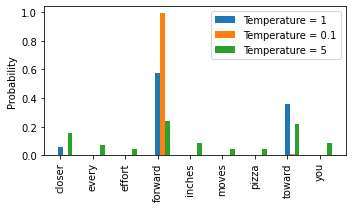

In [32]:
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

<div class="alert alert-block alert-info">

A temperature of 1 divides the logits by 1 before passing them to the softmax function to
compute the probability scores. 

In other words, using a temperature of 1 is the same as not
using any temperature scaling. 

In this case, the tokens are selected with a probability equal
to the original softmax probability scores via the multinomial sampling function in PyTorch.    
</div>

<div class="alert alert-block alert-info">

Applying very small temperatures, such as 0.1, will
result in sharper distributions such that the behavior of the multinomial function selects
the most likely token (here: "forward") almost 100% of the time, approaching the
behavior of the argmax function. 

Vice versa, a temperature of 5 results in a more uniform
distribution where other tokens are selected more often. 

This can add more variety to the
generated texts but also more often results in nonsensical text. 

For example, using the
temperature of 5 results in texts such as "every effort moves you pizza" about 4% of
the time.
    
</div>